In [1]:
# 5000
# NEW new normalizations
# NOT normalizing the inputs
# normalizing outputs
# no more train_test_split
# trialing epochs
#trialing validations
# trial various activation functions

# Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
import keras_metrics as km
import keras
from keras import metrics

gpu_num = 0

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-11-14 13:08:47.883677: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 13:08:47.925240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 13:08:48.558545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/braun2/anaconda3/envs/tf/lib/python3.8/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable local

2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


2023-11-14 13:08:50.704357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45808 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2023-11-14 13:08:50.704862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46258 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [3]:
gamma0_real = np.loadtxt("eos_polytrope_gamma_0-5000.dat.txt", dtype=float)
gamma1_real = np.loadtxt("eos_polytrope_gamma_1-5000.dat.txt", dtype=float)
gamma2_real = np.loadtxt("eos_polytrope_gamma_2-5000.dat.txt", dtype=float)
l1_real = np.loadtxt('lambda_1-5000.dat.txt', dtype=float)
l2_real = np.loadtxt('lambda_2-5000.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-5000.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-5000.dat.txt", dtype=float)
m1_real = np.loadtxt("mass_1_source-5000.dat.txt", dtype=float)
m2_real = np.loadtxt("mass_2_source-5000.dat.txt", dtype=float)

In [4]:
len(m2_real)

5000

In [5]:
m1_dat = m1_real
m2_dat = m2_real
l1_dat = l1_real
l2_dat = l2_real

# Functions

In [6]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [7]:
#return inputs back to original values in order to plot EOS

# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]


# unnorm function 1
def unnorm(predictionsarray):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * (5 - 1) + 1
        new_gamma1_array = predictionsarray[1] * (5 - 1) + 1
        new_gamma2_array = predictionsarray[2] * (5 - 1) + 1
        
        #cgs
        cgs_logp1 = predictionsarray[3]
        cgs_logp2 = predictionsarray[4]
        
        #normalize in si
        si_logp1_unnorm = cgs_logp1 * ((37-1) - (33-1)) + (33-1) +1
        si_logp2_unnorm = cgs_logp2 * ((37-1) - (33-1)) + (33-1) +1
        
        
        #convert back to si
        #new_logp1_array = cgs_logp1_unnorm - 1
        #new_logp2_array = cgs_logp2_unnorm - 1
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, si_logp1_unnorm, si_logp2_unnorm), axis=1)

    return new_array



# unnorm function 2
def minmaxunnorm(predictionsarray):

    for i in range (len(predictionsarray)):
        
        gam0 = predictionsarray[0]
        gam1 = predictionsarray[1]
        gam2 = predictionsarray[2]
        
        gam0max = np.max(predictionsarray[0])
        gam0min = np.min(predictionsarray[0])
        
        gam1max = np.max(predictionsarray[1])
        gam1min = np.min(predictionsarray[1])
        
        gam2max = np.max(predictionsarray[2])
        gam2min = np.min(predictionsarray[2])
        
        new_gamma0_array = (5 - 1)*((gam0 - gam0min)/(gam0max-gam0min)) + 1
        new_gamma1_array = (5 - 1)*((gam1 - gam1min)/(gam1max-gam1min)) + 1
        new_gamma2_array = (5 - 1)*((gam2 - gam2min)/(gam2max-gam2min)) + 1

        
        
        si_logp1 = predictionsarray[3]
        si_logp2 = predictionsarray[4]
        
        logp1max = np.max(si_logp1)
        logp1min = np.min(si_logp1)
        
        logp2max = np.max(si_logp2)
        logp2min = np.min(si_logp2)
        
        #minmax normalization
        
        #range [a,b]
        #measured min: min
        #measured max: max
        #array = x
        
        # (b - a) ((x - min)/(max-min)) + a
        # [32, 36]
        
        new_logp1_array = (36 - 32)*((si_logp1 - logp1min)/(logp1max-logp1min)) + 32
        new_logp2_array = (36 - 32)*((si_logp2 - logp2min)/(logp2max-logp2min)) + 32
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array


In [29]:
print(l1_real)

[   48.53885965 42688.43330165   167.80540992 ...   164.07159632
   139.40427306 34367.9876868 ]


# MLA

In [8]:
#normalizing to be between 0 and 1!


# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

#normalizing into si (using bounds 32 and 36)

logp1_s_norm = ((logp1_cgs - 1) - (33-1))/((37-1) - (33-1))
logp2_s_norm = ((logp2_cgs - 1) - (33-1))/((37-1) - (33-1))

logp1_si = logp1_s_norm
logp2_si = logp2_s_norm


sd_gamma0 = (gamma0_real - 1)/(5 - 1)
sd_gamma1 = (gamma1_real - 1)/(5 - 1)
sd_gamma2 = (gamma2_real - 1)/(5 - 1)


un-normalized outputs

1.0165505391256724
4.999447996952166


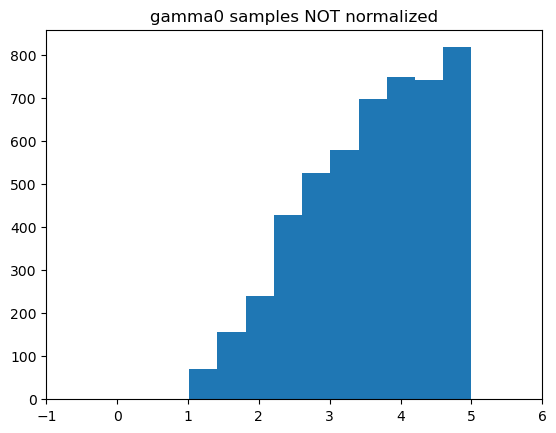

1.0004706315315508
4.999282270964101


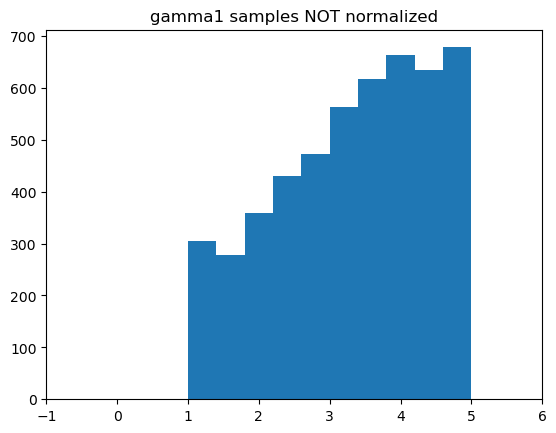

1.0002005834875753
2.957224084475217


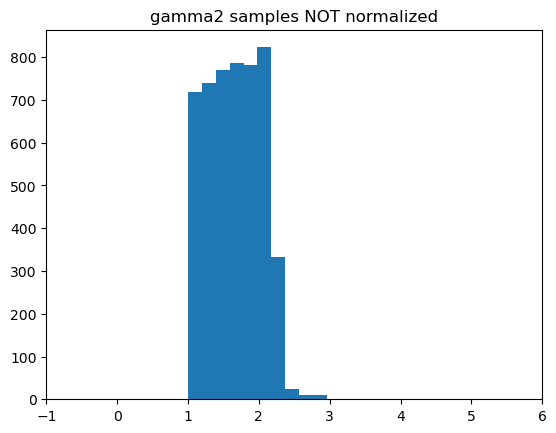

0.00010534888203039827
0.9868094544985553


0.014454813507407849
0.9999909738448292


In [28]:
plt.hist(gamma0_real[0:5000])
plt.title("gamma0 samples NOT normalized")
print(np.min(gamma0_real))
print(np.max(gamma0_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma1_real[0:5000])
plt.title("gamma1 samples NOT normalized")
print(np.min(gamma1_real))
print(np.max(gamma1_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma2_real[0:5000])
plt.title("gamma2 samples NOT normalized")
print(np.min(gamma2_real))
print(np.max(gamma2_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(l1_real[0:5000])
plt.title("logp1_si samples NOT normalized")
print(np.min(logp1_si))
print(np.max(logp1_si))
#plt.xlim(-.4, 1)
plt.show()

plt.hist(l2_real[0:5000])
plt.title("logp2_si samples NOT normalized")
print(np.min(logp2_si))
print(np.max(logp2_si))
#plt.xlim(-.4, 1)
plt.show()

normalized outputs

0.004137634781418098
0.9998619992380415


0.00011765788288770063
0.9998205677410252


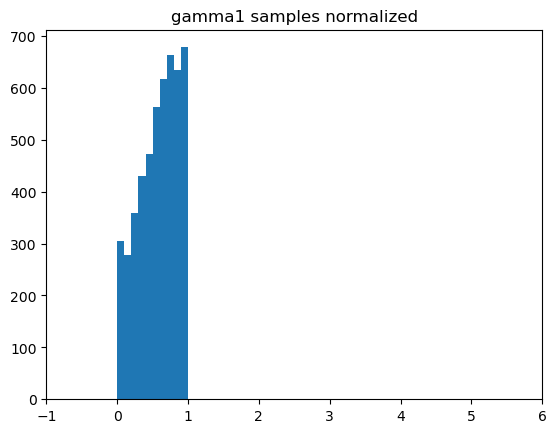

5.014587189383635e-05
0.4893060211188043


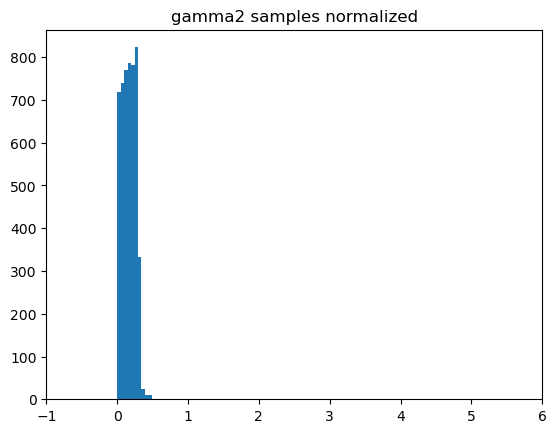

0.00010534888203039827
0.9868094544985553


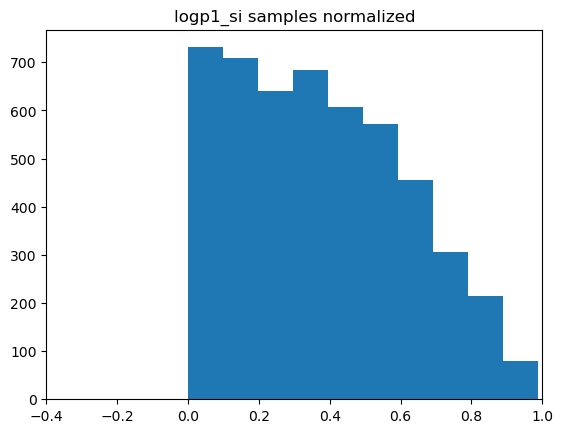

0.014454813507407849
0.9999909738448292


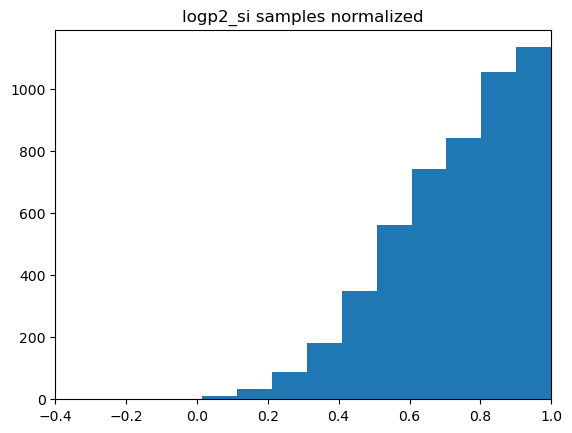

In [10]:
plt.hist(sd_gamma0[0:5000])
plt.title("gamma0 samples normalized")
print(np.min(sd_gamma0))
print(np.max(sd_gamma0))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma1[0:5000])
plt.title("gamma1 samples normalized")
print(np.min(sd_gamma1))
print(np.max(sd_gamma1))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma2[0:5000])
plt.title("gamma2 samples normalized")
print(np.min(sd_gamma2))
print(np.max(sd_gamma2))
plt.xlim(-1, 6)
plt.show()

plt.hist(logp1_si[0:5000])
plt.title("logp1_si samples normalized")
print(np.min(logp1_si))
print(np.max(logp1_si))
plt.xlim(-.4, 1)
plt.show()

plt.hist(logp2_si[0:5000])
plt.title("logp2_si samples normalized")
print(np.min(logp2_si))
print(np.max(logp2_si))
plt.xlim(-.4, 1)
plt.show()

In [11]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(5000, 9)


In [12]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [13]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

            m1        m2            l1            l2    gamma0    gamma1  \
0     1.704363  0.940013     48.538860     48.538860  0.437453  0.790931   
1     0.674195  0.488352  42688.433302  42688.433302  0.648856  0.745487   
2     1.944506  1.625537    167.805410    167.805410  0.630087  0.988135   
3     0.582582  0.362044  48488.884176  48488.884176  0.479282  0.037464   
4     2.684166  2.462512     51.173074     51.173074  0.813159  0.580368   
...        ...       ...           ...           ...       ...       ...   
4995  1.219522  0.363914   2652.644253   2652.644253  0.654295  0.767087   
4996  1.618197  1.317480    963.806577    963.806577  0.798642  0.653282   
4997  2.071077  0.830028    164.071596    164.071596  0.698157  0.350317   
4998  1.398519  1.139113    139.404273    139.404273  0.883617  0.297544   
4999  0.000000  0.000000      0.000000      0.000000  0.000000  0.000000   

        gamma2  logp1_si  logp2_si  
0     0.034513  0.591370  0.691493  
1     0.14847

In [14]:
# 541 total samples: 80% = 432, 20% = 108.2
# for train and test ONLY:
# we want the first 432 samples to = train
# we want the last 109 samples to = test
# split row-wise, not collumn-wise

# splitting dataframe by row index
train = data.iloc[:int(len(m2_real)*.8),:]
test = data.iloc[int(len(m2_real)*.8):,:]
print("Shape of new dataframes - {} , {}".format(train.shape, test.shape))

train_stats = train.describe()

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)


Shape of new dataframes - (4000, 9) , (1000, 9)


In [15]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

            m1        m2            l1            l2    gamma0    gamma1  \
372   1.585071  1.377963    464.647760    464.647760  0.602921  0.562352   
4643  2.704784  2.040321      9.422933      9.422933  0.596406  0.994514   
3143  2.044845  1.293412    207.537401    207.537401  0.729611  0.731419   
1601  0.555017  0.303082  56268.035530  56268.035530  0.460985  0.849755   
2633  2.211626  1.806962    123.592567    123.592567  0.723790  0.181078   
...        ...       ...           ...           ...       ...       ...   
4757  1.399349  0.436433   2377.500114   2377.500114  0.946566  0.724141   
785   0.979000  0.618245   3971.122348   3971.122348  0.499558  0.489453   
301   0.625567  0.501989  23999.401063  23999.401063  0.416775  0.355730   
99    2.518110  1.020259     71.314845     71.314845  0.631054  0.985725   
3958  1.556386  0.577050   1734.959695   1734.959695  0.992677  0.291248   

        gamma2  logp1_si  logp2_si  
372   0.155377  0.235358  0.724000  
4643  0.10260

In [16]:
norm_train_X = train
norm_test_X = test

In [17]:
input_layer = Input(shape=(len(train .columns),))
#input_layer = Input(shape=(4,))

In [18]:
len(train .columns)

4

In [19]:
layeract = 'tanh'
outputact = 'sigmoid'

In [20]:
first_dense = Dense(units='128', activation=layeract)(input_layer)


In [21]:
second_dense = Dense(units='128', activation=layeract)(first_dense)
third_dense = Dense(units='128', activation=layeract)(second_dense)
fourth_dense = Dense(units='128', activation=layeract)(third_dense)
fifth_dense = Dense(units='128', activation=layeract)(fourth_dense)
sixth_dense = Dense(units='128', activation=layeract)(fifth_dense)
seventh_dense = Dense(units='128', activation=layeract)(sixth_dense)
eight_dense = Dense(units='128', activation=layeract)(seventh_dense)
ninth_dense = Dense(units='128', activation=layeract)(eight_dense)
    
tenth_dense = Dense(units='128', activation=layeract)(ninth_dense)
eleventh_dense = Dense(units='128', activation=layeract)(tenth_dense)
twelth_dense = Dense(units='128', activation=layeract)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=layeract)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=layeract)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=layeract)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=layeract)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=layeract)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=layeract)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=layeract)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=layeract)(nineteenth_dense)
tf_dense = Dense(units='128', activation=layeract)(twentieth_dense)
ts_dense = Dense(units='128', activation=layeract)(tf_dense)
tt_dense = Dense(units='128', activation=layeract)(ts_dense)
tfo_dense = Dense(units='128', activation=layeract)(tt_dense)
tfi_dense = Dense(units='128', activation=layeract)(tfo_dense)
ts_dense = Dense(units='128', activation=layeract)(tfi_dense)
tse_dense = Dense(units='128', activation=layeract)(ts_dense)
te_dense = Dense(units='128', activation=layeract)(tse_dense)
tn_dense = Dense(units='128', activation=layeract)(te_dense)


gamma0_output = Dense(units='1', activation=outputact, name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation=layeract)(tn_dense)

ths_dense = Dense(units='128', activation=layeract)(thf_dense)
tht_dense = Dense(units='128', activation=layeract)(ths_dense)
thfo_dense = Dense(units='128', activation=layeract)(tht_dense)
thfi_dense = Dense(units='128', activation=layeract)(thfo_dense)
ths_dense = Dense(units='128', activation=layeract)(thfi_dense)
thse_dense = Dense(units='128', activation=layeract)(ths_dense)
the_dense = Dense(units='128', activation=layeract)(thse_dense)
thn_dense = Dense(units='128', activation=layeract)(the_dense)

gamma1_output = Dense(units='1', activation=outputact, name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation=layeract)(thn_dense)

fof_dense = Dense(units='128', activation=layeract)(fo_dense)
fos_dense = Dense(units='128', activation=layeract)(fof_dense)
fot_dense = Dense(units='128', activation=layeract)(fos_dense)
fofo_dense = Dense(units='128', activation=layeract)(fot_dense)
fofi_dense = Dense(units='128', activation=layeract)(fofo_dense)

gamma2_output = Dense(units='1', activation=outputact, name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation=layeract)(fofi_dense)

fose_dense = Dense(units='128', activation=layeract)(fos_dense)
foe_dense = Dense(units='128', activation=layeract)(fose_dense)
fon_dense = Dense(units='128', activation=layeract)(foe_dense)
fif_dense = Dense(units='128', activation=layeract)(fon_dense)

logp1_si_output = Dense(units='1', activation=outputact, name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation=layeract)(fon_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiff_dense)
fift_dense = Dense(units='128', activation=layeract)(fifs_dense)
fiff_dense = Dense(units='128', activation=layeract)(fift_dense)
fiffi_dense = Dense(units='128', activation=layeract)(fiff_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiffi_dense)

logp2_si_output = Dense(units='1', activation=outputact, name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  640       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']             
                                                                                              

 dense_39 (Dense)            (None, 128)                  4224      ['dense_38[0][0]']            
                                                                                                  
 dense_40 (Dense)            (None, 128)                  16512     ['dense_39[0][0]']            
                                                                                                  
 dense_41 (Dense)            (None, 128)                  16512     ['dense_40[0][0]']            
                                                                                                  
 dense_42 (Dense)            (None, 128)                  16512     ['dense_41[0][0]']            
                                                                                                  
 dense_43 (Dense)            (None, 128)                  16512     ['dense_42[0][0]']            
                                                                                                  
 dense_44 

In [22]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [23]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [24]:
#train the model for a number of epochs

numepochs = 500
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=200,mode='auto')])


Epoch 1/500


2023-11-14 13:09:06.977243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 13:09:06.979536: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14d3a244e8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 13:09:06.979551: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-14 13:09:06.979555: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-14 13:09:06.983418: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 13:09:07.117298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 13:09:07.19348

320/320 [==============================] - 13s 10ms/step - loss: 0.2403 - gamma0_output_loss: 0.0585 - gamma1_output_loss: 0.0753 - gamma2_output_loss: 0.0102 - logp1_si_output_loss: 0.0585 - logp2_si_output_loss: 0.0378 - gamma0_output_mean_squared_error: 0.0585 - gamma1_output_mean_squared_error: 0.0753 - gamma2_output_mean_squared_error: 0.0102 - logp1_si_output_mean_squared_error: 0.0585 - logp2_si_output_mean_squared_error: 0.0378 - val_loss: 0.2306 - val_gamma0_output_loss: 0.0530 - val_gamma1_output_loss: 0.0726 - val_gamma2_output_loss: 0.0097 - val_logp1_si_output_loss: 0.0573 - val_logp2_si_output_loss: 0.0380 - val_gamma0_output_mean_squared_error: 0.0530 - val_gamma1_output_mean_squared_error: 0.0726 - val_gamma2_output_mean_squared_error: 0.0097 - val_logp1_si_output_mean_squared_error: 0.0573 - val_logp2_si_output_mean_squared_error: 0.0380
Epoch 2/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2359 - gamma0_output_loss: 0.0573 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2236 - gamma0_output_loss: 0.0476 - gamma1_output_loss: 0.0732 - gamma2_output_loss: 0.0088 - logp1_si_output_loss: 0.0581 - logp2_si_output_loss: 0.0360 - gamma0_output_mean_squared_error: 0.0476 - gamma1_output_mean_squared_error: 0.0732 - gamma2_output_mean_squared_error: 0.0088 - logp1_si_output_mean_squared_error: 0.0581 - logp2_si_output_mean_squared_error: 0.0360 - val_loss: 0.2140 - val_gamma0_output_loss: 0.0390 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0085 - val_logp1_si_output_loss: 0.0567 - val_logp2_si_output_loss: 0.0377 - val_gamma0_output_mean_squared_error: 0.0390 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0085 - val_logp1_si_output_mean_squared_error: 0.0567 - val_logp2_si_output_mean_squared_error: 0.0377
Epoch 11/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2223 - gamma0_output_loss: 0.0466 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2188 - gamma0_output_loss: 0.0438 - gamma1_output_loss: 0.0726 - gamma2_output_loss: 0.0087 - logp1_si_output_loss: 0.0579 - logp2_si_output_loss: 0.0358 - gamma0_output_mean_squared_error: 0.0438 - gamma1_output_mean_squared_error: 0.0726 - gamma2_output_mean_squared_error: 0.0087 - logp1_si_output_mean_squared_error: 0.0579 - logp2_si_output_mean_squared_error: 0.0358 - val_loss: 0.2106 - val_gamma0_output_loss: 0.0394 - val_gamma1_output_loss: 0.0708 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0562 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0394 - val_gamma1_output_mean_squared_error: 0.0708 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0562 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 20/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2176 - gamma0_output_loss: 0.0430 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2179 - gamma0_output_loss: 0.0435 - gamma1_output_loss: 0.0724 - gamma2_output_loss: 0.0087 - logp1_si_output_loss: 0.0576 - logp2_si_output_loss: 0.0358 - gamma0_output_mean_squared_error: 0.0435 - gamma1_output_mean_squared_error: 0.0724 - gamma2_output_mean_squared_error: 0.0087 - logp1_si_output_mean_squared_error: 0.0576 - logp2_si_output_mean_squared_error: 0.0358 - val_loss: 0.2233 - val_gamma0_output_loss: 0.0468 - val_gamma1_output_loss: 0.0724 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0584 - val_logp2_si_output_loss: 0.0375 - val_gamma0_output_mean_squared_error: 0.0468 - val_gamma1_output_mean_squared_error: 0.0724 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0584 - val_logp2_si_output_mean_squared_error: 0.0375
Epoch 29/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2177 - gamma0_output_loss: 0.0432 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2167 - gamma0_output_loss: 0.0420 - gamma1_output_loss: 0.0728 - gamma2_output_loss: 0.0087 - logp1_si_output_loss: 0.0577 - logp2_si_output_loss: 0.0356 - gamma0_output_mean_squared_error: 0.0420 - gamma1_output_mean_squared_error: 0.0728 - gamma2_output_mean_squared_error: 0.0087 - logp1_si_output_mean_squared_error: 0.0577 - logp2_si_output_mean_squared_error: 0.0356 - val_loss: 0.2133 - val_gamma0_output_loss: 0.0412 - val_gamma1_output_loss: 0.0715 - val_gamma2_output_loss: 0.0084 - val_logp1_si_output_loss: 0.0563 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0412 - val_gamma1_output_mean_squared_error: 0.0715 - val_gamma2_output_mean_squared_error: 0.0084 - val_logp1_si_output_mean_squared_error: 0.0563 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 38/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2169 - gamma0_output_loss: 0.0422 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2152 - gamma0_output_loss: 0.0411 - gamma1_output_loss: 0.0724 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0577 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0411 - gamma1_output_mean_squared_error: 0.0724 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0577 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2069 - val_gamma0_output_loss: 0.0362 - val_gamma1_output_loss: 0.0709 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0357 - val_gamma0_output_mean_squared_error: 0.0362 - val_gamma1_output_mean_squared_error: 0.0709 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0357
Epoch 47/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2158 - gamma0_output_loss: 0.0418 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2170 - gamma0_output_loss: 0.0422 - gamma1_output_loss: 0.0729 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0577 - logp2_si_output_loss: 0.0355 - gamma0_output_mean_squared_error: 0.0422 - gamma1_output_mean_squared_error: 0.0729 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0577 - logp2_si_output_mean_squared_error: 0.0355 - val_loss: 0.2078 - val_gamma0_output_loss: 0.0363 - val_gamma1_output_loss: 0.0707 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0563 - val_logp2_si_output_loss: 0.0364 - val_gamma0_output_mean_squared_error: 0.0363 - val_gamma1_output_mean_squared_error: 0.0707 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0563 - val_logp2_si_output_mean_squared_error: 0.0364
Epoch 56/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2160 - gamma0_output_loss: 0.0419 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2149 - gamma0_output_loss: 0.0405 - gamma1_output_loss: 0.0725 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0577 - logp2_si_output_loss: 0.0356 - gamma0_output_mean_squared_error: 0.0405 - gamma1_output_mean_squared_error: 0.0725 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0577 - logp2_si_output_mean_squared_error: 0.0356 - val_loss: 0.2077 - val_gamma0_output_loss: 0.0352 - val_gamma1_output_loss: 0.0716 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0562 - val_logp2_si_output_loss: 0.0365 - val_gamma0_output_mean_squared_error: 0.0352 - val_gamma1_output_mean_squared_error: 0.0716 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0562 - val_logp2_si_output_mean_squared_error: 0.0365
Epoch 65/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2142 - gamma0_output_loss: 0.0401 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2157 - gamma0_output_loss: 0.0416 - gamma1_output_loss: 0.0724 - gamma2_output_loss: 0.0087 - logp1_si_output_loss: 0.0576 - logp2_si_output_loss: 0.0355 - gamma0_output_mean_squared_error: 0.0416 - gamma1_output_mean_squared_error: 0.0724 - gamma2_output_mean_squared_error: 0.0087 - logp1_si_output_mean_squared_error: 0.0576 - logp2_si_output_mean_squared_error: 0.0355 - val_loss: 0.2126 - val_gamma0_output_loss: 0.0413 - val_gamma1_output_loss: 0.0707 - val_gamma2_output_loss: 0.0083 - val_logp1_si_output_loss: 0.0562 - val_logp2_si_output_loss: 0.0361 - val_gamma0_output_mean_squared_error: 0.0413 - val_gamma1_output_mean_squared_error: 0.0707 - val_gamma2_output_mean_squared_error: 0.0083 - val_logp1_si_output_mean_squared_error: 0.0562 - val_logp2_si_output_mean_squared_error: 0.0361
Epoch 74/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2149 - gamma0_output_loss: 0.0405 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2143 - gamma0_output_loss: 0.0403 - gamma1_output_loss: 0.0727 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0403 - gamma1_output_mean_squared_error: 0.0727 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2072 - val_gamma0_output_loss: 0.0371 - val_gamma1_output_loss: 0.0706 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0555 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0371 - val_gamma1_output_mean_squared_error: 0.0706 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0555 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 83/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2127 - gamma0_output_loss: 0.0391 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2119 - gamma0_output_loss: 0.0385 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0385 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2054 - val_gamma0_output_loss: 0.0344 - val_gamma1_output_loss: 0.0713 - val_gamma2_output_loss: 0.0083 - val_logp1_si_output_loss: 0.0556 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0344 - val_gamma1_output_mean_squared_error: 0.0713 - val_gamma2_output_mean_squared_error: 0.0083 - val_logp1_si_output_mean_squared_error: 0.0556 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 92/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2128 - gamma0_output_loss: 0.0392 - gamma1_output_loss: 0

320/320 [==============================] - 3s 9ms/step - loss: 0.2130 - gamma0_output_loss: 0.0392 - gamma1_output_loss: 0.0723 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0575 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0392 - gamma1_output_mean_squared_error: 0.0723 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0575 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2058 - val_gamma0_output_loss: 0.0348 - val_gamma1_output_loss: 0.0709 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0560 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0348 - val_gamma1_output_mean_squared_error: 0.0709 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0560 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 101/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2124 - gamma0_output_loss: 0.0387 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2142 - gamma0_output_loss: 0.0404 - gamma1_output_loss: 0.0723 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0575 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0404 - gamma1_output_mean_squared_error: 0.0723 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0575 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2066 - val_gamma0_output_loss: 0.0355 - val_gamma1_output_loss: 0.0703 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0569 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0355 - val_gamma1_output_mean_squared_error: 0.0703 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0569 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 110/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2114 - gamma0_output_loss: 0.0380 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2132 - gamma0_output_loss: 0.0396 - gamma1_output_loss: 0.0725 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0396 - gamma1_output_mean_squared_error: 0.0725 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2058 - val_gamma0_output_loss: 0.0355 - val_gamma1_output_loss: 0.0704 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0355 - val_gamma1_output_mean_squared_error: 0.0704 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 119/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2135 - gamma0_output_loss: 0.0396 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2127 - gamma0_output_loss: 0.0392 - gamma1_output_loss: 0.0724 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0392 - gamma1_output_mean_squared_error: 0.0724 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2077 - val_gamma0_output_loss: 0.0371 - val_gamma1_output_loss: 0.0709 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0560 - val_logp2_si_output_loss: 0.0355 - val_gamma0_output_mean_squared_error: 0.0371 - val_gamma1_output_mean_squared_error: 0.0709 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0560 - val_logp2_si_output_mean_squared_error: 0.0355
Epoch 128/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2152 - gamma0_output_loss: 0.0410 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2117 - gamma0_output_loss: 0.0384 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0572 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0384 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0572 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2043 - val_gamma0_output_loss: 0.0339 - val_gamma1_output_loss: 0.0710 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0555 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0339 - val_gamma1_output_mean_squared_error: 0.0710 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0555 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 137/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2125 - gamma0_output_loss: 0.0392 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2116 - gamma0_output_loss: 0.0383 - gamma1_output_loss: 0.0723 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0383 - gamma1_output_mean_squared_error: 0.0723 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2073 - val_gamma0_output_loss: 0.0343 - val_gamma1_output_loss: 0.0721 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0564 - val_logp2_si_output_loss: 0.0363 - val_gamma0_output_mean_squared_error: 0.0343 - val_gamma1_output_mean_squared_error: 0.0721 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0564 - val_logp2_si_output_mean_squared_error: 0.0363
Epoch 146/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2128 - gamma0_output_loss: 0.0391 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2113 - gamma0_output_loss: 0.0378 - gamma1_output_loss: 0.0724 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0378 - gamma1_output_mean_squared_error: 0.0724 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2129 - val_gamma0_output_loss: 0.0422 - val_gamma1_output_loss: 0.0706 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0561 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0422 - val_gamma1_output_mean_squared_error: 0.0706 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0561 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 155/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2137 - gamma0_output_loss: 0.0401 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2117 - gamma0_output_loss: 0.0384 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0384 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2026 - val_gamma0_output_loss: 0.0325 - val_gamma1_output_loss: 0.0704 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0557 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0325 - val_gamma1_output_mean_squared_error: 0.0704 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0557 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 164/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2106 - gamma0_output_loss: 0.0374 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2105 - gamma0_output_loss: 0.0375 - gamma1_output_loss: 0.0719 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0375 - gamma1_output_mean_squared_error: 0.0719 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2043 - val_gamma0_output_loss: 0.0346 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0556 - val_logp2_si_output_loss: 0.0357 - val_gamma0_output_mean_squared_error: 0.0346 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0556 - val_logp2_si_output_mean_squared_error: 0.0357
Epoch 173/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2113 - gamma0_output_loss: 0.0385 - gamma1_output_loss: 

320/320 [==============================] - 3s 8ms/step - loss: 0.2129 - gamma0_output_loss: 0.0393 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0575 - logp2_si_output_loss: 0.0355 - gamma0_output_mean_squared_error: 0.0393 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0575 - logp2_si_output_mean_squared_error: 0.0355 - val_loss: 0.2032 - val_gamma0_output_loss: 0.0329 - val_gamma1_output_loss: 0.0706 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0558 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0329 - val_gamma1_output_mean_squared_error: 0.0706 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0558 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 182/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2128 - gamma0_output_loss: 0.0393 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2108 - gamma0_output_loss: 0.0376 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0376 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2146 - val_gamma0_output_loss: 0.0433 - val_gamma1_output_loss: 0.0703 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0568 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0433 - val_gamma1_output_mean_squared_error: 0.0703 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0568 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 191/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2110 - gamma0_output_loss: 0.0380 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2120 - gamma0_output_loss: 0.0390 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0390 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2210 - val_gamma0_output_loss: 0.0484 - val_gamma1_output_loss: 0.0709 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0569 - val_logp2_si_output_loss: 0.0365 - val_gamma0_output_mean_squared_error: 0.0484 - val_gamma1_output_mean_squared_error: 0.0709 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0569 - val_logp2_si_output_mean_squared_error: 0.0365
Epoch 200/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2120 - gamma0_output_loss: 0.0385 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2109 - gamma0_output_loss: 0.0377 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0377 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2072 - val_gamma0_output_loss: 0.0368 - val_gamma1_output_loss: 0.0704 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0560 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0368 - val_gamma1_output_mean_squared_error: 0.0704 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0560 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 209/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2124 - gamma0_output_loss: 0.0390 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2106 - gamma0_output_loss: 0.0370 - gamma1_output_loss: 0.0723 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0370 - gamma1_output_mean_squared_error: 0.0723 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2087 - val_gamma0_output_loss: 0.0372 - val_gamma1_output_loss: 0.0713 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0564 - val_logp2_si_output_loss: 0.0356 - val_gamma0_output_mean_squared_error: 0.0372 - val_gamma1_output_mean_squared_error: 0.0713 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0564 - val_logp2_si_output_mean_squared_error: 0.0356
Epoch 218/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2117 - gamma0_output_loss: 0.0383 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2104 - gamma0_output_loss: 0.0374 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0572 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0374 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0572 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2038 - val_gamma0_output_loss: 0.0329 - val_gamma1_output_loss: 0.0704 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0560 - val_logp2_si_output_loss: 0.0363 - val_gamma0_output_mean_squared_error: 0.0329 - val_gamma1_output_mean_squared_error: 0.0704 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0560 - val_logp2_si_output_mean_squared_error: 0.0363
Epoch 227/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2103 - gamma0_output_loss: 0.0372 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2127 - gamma0_output_loss: 0.0389 - gamma1_output_loss: 0.0724 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0389 - gamma1_output_mean_squared_error: 0.0724 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2066 - val_gamma0_output_loss: 0.0348 - val_gamma1_output_loss: 0.0708 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0566 - val_logp2_si_output_loss: 0.0363 - val_gamma0_output_mean_squared_error: 0.0348 - val_gamma1_output_mean_squared_error: 0.0708 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0566 - val_logp2_si_output_mean_squared_error: 0.0363
Epoch 236/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2110 - gamma0_output_loss: 0.0381 - gamma1_output_loss: 

320/320 [==============================] - 3s 8ms/step - loss: 0.2109 - gamma0_output_loss: 0.0378 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0378 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2069 - val_gamma0_output_loss: 0.0362 - val_gamma1_output_loss: 0.0709 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0556 - val_logp2_si_output_loss: 0.0361 - val_gamma0_output_mean_squared_error: 0.0362 - val_gamma1_output_mean_squared_error: 0.0709 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0556 - val_logp2_si_output_mean_squared_error: 0.0361
Epoch 245/500
320/320 [==============================] - 3s 8ms/step - loss: 0.2106 - gamma0_output_loss: 0.0376 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2107 - gamma0_output_loss: 0.0374 - gamma1_output_loss: 0.0723 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0374 - gamma1_output_mean_squared_error: 0.0723 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2091 - val_gamma0_output_loss: 0.0384 - val_gamma1_output_loss: 0.0703 - val_gamma2_output_loss: 0.0083 - val_logp1_si_output_loss: 0.0564 - val_logp2_si_output_loss: 0.0357 - val_gamma0_output_mean_squared_error: 0.0384 - val_gamma1_output_mean_squared_error: 0.0703 - val_gamma2_output_mean_squared_error: 0.0083 - val_logp1_si_output_mean_squared_error: 0.0564 - val_logp2_si_output_mean_squared_error: 0.0357
Epoch 254/500
320/320 [==============================] - 3s 8ms/step - loss: 0.2113 - gamma0_output_loss: 0.0381 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2105 - gamma0_output_loss: 0.0373 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0373 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2027 - val_gamma0_output_loss: 0.0331 - val_gamma1_output_loss: 0.0701 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0556 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0331 - val_gamma1_output_mean_squared_error: 0.0701 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0556 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 263/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2098 - gamma0_output_loss: 0.0367 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2096 - gamma0_output_loss: 0.0369 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0351 - gamma0_output_mean_squared_error: 0.0369 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0351 - val_loss: 0.2088 - val_gamma0_output_loss: 0.0382 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0362 - val_gamma0_output_mean_squared_error: 0.0382 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0362
Epoch 272/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2099 - gamma0_output_loss: 0.0369 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2111 - gamma0_output_loss: 0.0380 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0572 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0380 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0572 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2092 - val_gamma0_output_loss: 0.0388 - val_gamma1_output_loss: 0.0705 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0560 - val_logp2_si_output_loss: 0.0357 - val_gamma0_output_mean_squared_error: 0.0388 - val_gamma1_output_mean_squared_error: 0.0705 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0560 - val_logp2_si_output_mean_squared_error: 0.0357
Epoch 281/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2102 - gamma0_output_loss: 0.0372 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2107 - gamma0_output_loss: 0.0378 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0569 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0378 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0569 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2065 - val_gamma0_output_loss: 0.0363 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0557 - val_logp2_si_output_loss: 0.0360 - val_gamma0_output_mean_squared_error: 0.0363 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0557 - val_logp2_si_output_mean_squared_error: 0.0360
Epoch 290/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2111 - gamma0_output_loss: 0.0378 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2110 - gamma0_output_loss: 0.0378 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0378 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2081 - val_gamma0_output_loss: 0.0377 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0361 - val_gamma0_output_mean_squared_error: 0.0377 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0361
Epoch 299/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2104 - gamma0_output_loss: 0.0373 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2110 - gamma0_output_loss: 0.0381 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0085 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0381 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0085 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2040 - val_gamma0_output_loss: 0.0335 - val_gamma1_output_loss: 0.0706 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0558 - val_logp2_si_output_loss: 0.0360 - val_gamma0_output_mean_squared_error: 0.0335 - val_gamma1_output_mean_squared_error: 0.0706 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0558 - val_logp2_si_output_mean_squared_error: 0.0360
Epoch 308/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2098 - gamma0_output_loss: 0.0367 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2099 - gamma0_output_loss: 0.0370 - gamma1_output_loss: 0.0718 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0573 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0370 - gamma1_output_mean_squared_error: 0.0718 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0573 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2099 - val_gamma0_output_loss: 0.0382 - val_gamma1_output_loss: 0.0710 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0567 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0382 - val_gamma1_output_mean_squared_error: 0.0710 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0567 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 317/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2097 - gamma0_output_loss: 0.0367 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2117 - gamma0_output_loss: 0.0380 - gamma1_output_loss: 0.0724 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0356 - gamma0_output_mean_squared_error: 0.0380 - gamma1_output_mean_squared_error: 0.0724 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0356 - val_loss: 0.2151 - val_gamma0_output_loss: 0.0351 - val_gamma1_output_loss: 0.0779 - val_gamma2_output_loss: 0.0083 - val_logp1_si_output_loss: 0.0564 - val_logp2_si_output_loss: 0.0374 - val_gamma0_output_mean_squared_error: 0.0351 - val_gamma1_output_mean_squared_error: 0.0779 - val_gamma2_output_mean_squared_error: 0.0083 - val_logp1_si_output_mean_squared_error: 0.0564 - val_logp2_si_output_mean_squared_error: 0.0374
Epoch 326/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2132 - gamma0_output_loss: 0.0385 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2098 - gamma0_output_loss: 0.0369 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0085 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0369 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0085 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2097 - val_gamma0_output_loss: 0.0379 - val_gamma1_output_loss: 0.0708 - val_gamma2_output_loss: 0.0084 - val_logp1_si_output_loss: 0.0561 - val_logp2_si_output_loss: 0.0364 - val_gamma0_output_mean_squared_error: 0.0379 - val_gamma1_output_mean_squared_error: 0.0708 - val_gamma2_output_mean_squared_error: 0.0084 - val_logp1_si_output_mean_squared_error: 0.0561 - val_logp2_si_output_mean_squared_error: 0.0364
Epoch 335/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2107 - gamma0_output_loss: 0.0377 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2089 - gamma0_output_loss: 0.0359 - gamma1_output_loss: 0.0719 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0572 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0359 - gamma1_output_mean_squared_error: 0.0719 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0572 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2062 - val_gamma0_output_loss: 0.0356 - val_gamma1_output_loss: 0.0705 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0560 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0356 - val_gamma1_output_mean_squared_error: 0.0705 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0560 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 344/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2106 - gamma0_output_loss: 0.0376 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2094 - gamma0_output_loss: 0.0365 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0365 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2086 - val_gamma0_output_loss: 0.0373 - val_gamma1_output_loss: 0.0708 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0563 - val_logp2_si_output_loss: 0.0361 - val_gamma0_output_mean_squared_error: 0.0373 - val_gamma1_output_mean_squared_error: 0.0708 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0563 - val_logp2_si_output_mean_squared_error: 0.0361
Epoch 353/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2092 - gamma0_output_loss: 0.0363 - gamma1_output_loss: 

320/320 [==============================] - 3s 8ms/step - loss: 0.2095 - gamma0_output_loss: 0.0364 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0085 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0364 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0085 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2081 - val_gamma0_output_loss: 0.0371 - val_gamma1_output_loss: 0.0704 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0564 - val_logp2_si_output_loss: 0.0361 - val_gamma0_output_mean_squared_error: 0.0371 - val_gamma1_output_mean_squared_error: 0.0704 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0564 - val_logp2_si_output_mean_squared_error: 0.0361
Epoch 362/500
320/320 [==============================] - 3s 8ms/step - loss: 0.2094 - gamma0_output_loss: 0.0365 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2099 - gamma0_output_loss: 0.0369 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0369 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2065 - val_gamma0_output_loss: 0.0365 - val_gamma1_output_loss: 0.0703 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0555 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0365 - val_gamma1_output_mean_squared_error: 0.0703 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0555 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 371/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2116 - gamma0_output_loss: 0.0380 - gamma1_output_loss: 

320/320 [==============================] - 3s 8ms/step - loss: 0.2093 - gamma0_output_loss: 0.0363 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0572 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0363 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0572 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2020 - val_gamma0_output_loss: 0.0316 - val_gamma1_output_loss: 0.0705 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0316 - val_gamma1_output_mean_squared_error: 0.0705 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 380/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2089 - gamma0_output_loss: 0.0364 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2096 - gamma0_output_loss: 0.0368 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0368 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2050 - val_gamma0_output_loss: 0.0344 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0560 - val_logp2_si_output_loss: 0.0362 - val_gamma0_output_mean_squared_error: 0.0344 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0560 - val_logp2_si_output_mean_squared_error: 0.0362
Epoch 389/500
320/320 [==============================] - 3s 8ms/step - loss: 0.2086 - gamma0_output_loss: 0.0359 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2091 - gamma0_output_loss: 0.0367 - gamma1_output_loss: 0.0719 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0567 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0367 - gamma1_output_mean_squared_error: 0.0719 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0567 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2028 - val_gamma0_output_loss: 0.0324 - val_gamma1_output_loss: 0.0699 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0565 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0324 - val_gamma1_output_mean_squared_error: 0.0699 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0565 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 398/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2085 - gamma0_output_loss: 0.0358 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2090 - gamma0_output_loss: 0.0363 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0569 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0363 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0569 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2022 - val_gamma0_output_loss: 0.0315 - val_gamma1_output_loss: 0.0706 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0561 - val_logp2_si_output_loss: 0.0357 - val_gamma0_output_mean_squared_error: 0.0315 - val_gamma1_output_mean_squared_error: 0.0706 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0561 - val_logp2_si_output_mean_squared_error: 0.0357
Epoch 407/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2100 - gamma0_output_loss: 0.0372 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2090 - gamma0_output_loss: 0.0361 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0361 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2027 - val_gamma0_output_loss: 0.0315 - val_gamma1_output_loss: 0.0708 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0565 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0315 - val_gamma1_output_mean_squared_error: 0.0708 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0565 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 416/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2087 - gamma0_output_loss: 0.0361 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2091 - gamma0_output_loss: 0.0361 - gamma1_output_loss: 0.0717 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0572 - logp2_si_output_loss: 0.0355 - gamma0_output_mean_squared_error: 0.0361 - gamma1_output_mean_squared_error: 0.0717 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0572 - logp2_si_output_mean_squared_error: 0.0355 - val_loss: 0.2046 - val_gamma0_output_loss: 0.0348 - val_gamma1_output_loss: 0.0699 - val_gamma2_output_loss: 0.0083 - val_logp1_si_output_loss: 0.0556 - val_logp2_si_output_loss: 0.0361 - val_gamma0_output_mean_squared_error: 0.0348 - val_gamma1_output_mean_squared_error: 0.0699 - val_gamma2_output_mean_squared_error: 0.0083 - val_logp1_si_output_mean_squared_error: 0.0556 - val_logp2_si_output_mean_squared_error: 0.0361
Epoch 425/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2079 - gamma0_output_loss: 0.0352 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2084 - gamma0_output_loss: 0.0359 - gamma1_output_loss: 0.0717 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0359 - gamma1_output_mean_squared_error: 0.0717 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2085 - val_gamma0_output_loss: 0.0368 - val_gamma1_output_loss: 0.0709 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0566 - val_logp2_si_output_loss: 0.0360 - val_gamma0_output_mean_squared_error: 0.0368 - val_gamma1_output_mean_squared_error: 0.0709 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0566 - val_logp2_si_output_mean_squared_error: 0.0360
Epoch 434/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2094 - gamma0_output_loss: 0.0364 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2102 - gamma0_output_loss: 0.0373 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0373 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2054 - val_gamma0_output_loss: 0.0351 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0563 - val_logp2_si_output_loss: 0.0356 - val_gamma0_output_mean_squared_error: 0.0351 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0563 - val_logp2_si_output_mean_squared_error: 0.0356
Epoch 443/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2109 - gamma0_output_loss: 0.0381 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2097 - gamma0_output_loss: 0.0369 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0369 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2035 - val_gamma0_output_loss: 0.0333 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0556 - val_logp2_si_output_loss: 0.0362 - val_gamma0_output_mean_squared_error: 0.0333 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0556 - val_logp2_si_output_mean_squared_error: 0.0362
Epoch 452/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2096 - gamma0_output_loss: 0.0366 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2089 - gamma0_output_loss: 0.0361 - gamma1_output_loss: 0.0719 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0571 - logp2_si_output_loss: 0.0352 - gamma0_output_mean_squared_error: 0.0361 - gamma1_output_mean_squared_error: 0.0719 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0571 - logp2_si_output_mean_squared_error: 0.0352 - val_loss: 0.2066 - val_gamma0_output_loss: 0.0360 - val_gamma1_output_loss: 0.0706 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0360 - val_gamma1_output_mean_squared_error: 0.0706 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 461/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2099 - gamma0_output_loss: 0.0368 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2093 - gamma0_output_loss: 0.0369 - gamma1_output_loss: 0.0715 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0369 - gamma1_output_mean_squared_error: 0.0715 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2097 - val_gamma0_output_loss: 0.0388 - val_gamma1_output_loss: 0.0705 - val_gamma2_output_loss: 0.0082 - val_logp1_si_output_loss: 0.0562 - val_logp2_si_output_loss: 0.0358 - val_gamma0_output_mean_squared_error: 0.0388 - val_gamma1_output_mean_squared_error: 0.0705 - val_gamma2_output_mean_squared_error: 0.0082 - val_logp1_si_output_mean_squared_error: 0.0562 - val_logp2_si_output_mean_squared_error: 0.0358
Epoch 470/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2087 - gamma0_output_loss: 0.0359 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2086 - gamma0_output_loss: 0.0361 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0085 - logp1_si_output_loss: 0.0567 - logp2_si_output_loss: 0.0351 - gamma0_output_mean_squared_error: 0.0361 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0085 - logp1_si_output_mean_squared_error: 0.0567 - logp2_si_output_mean_squared_error: 0.0351 - val_loss: 0.2039 - val_gamma0_output_loss: 0.0340 - val_gamma1_output_loss: 0.0700 - val_gamma2_output_loss: 0.0084 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0357 - val_gamma0_output_mean_squared_error: 0.0340 - val_gamma1_output_mean_squared_error: 0.0700 - val_gamma2_output_mean_squared_error: 0.0084 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0357
Epoch 479/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2090 - gamma0_output_loss: 0.0362 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2089 - gamma0_output_loss: 0.0362 - gamma1_output_loss: 0.0719 - gamma2_output_loss: 0.0086 - logp1_si_output_loss: 0.0569 - logp2_si_output_loss: 0.0353 - gamma0_output_mean_squared_error: 0.0362 - gamma1_output_mean_squared_error: 0.0719 - gamma2_output_mean_squared_error: 0.0086 - logp1_si_output_mean_squared_error: 0.0569 - logp2_si_output_mean_squared_error: 0.0353 - val_loss: 0.2086 - val_gamma0_output_loss: 0.0385 - val_gamma1_output_loss: 0.0702 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0561 - val_logp2_si_output_loss: 0.0357 - val_gamma0_output_mean_squared_error: 0.0385 - val_gamma1_output_mean_squared_error: 0.0702 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0561 - val_logp2_si_output_mean_squared_error: 0.0357
Epoch 488/500
320/320 [==============================] - 3s 8ms/step - loss: 0.2094 - gamma0_output_loss: 0.0368 - gamma1_output_loss: 

320/320 [==============================] - 3s 9ms/step - loss: 0.2083 - gamma0_output_loss: 0.0356 - gamma1_output_loss: 0.0717 - gamma2_output_loss: 0.0085 - logp1_si_output_loss: 0.0570 - logp2_si_output_loss: 0.0354 - gamma0_output_mean_squared_error: 0.0356 - gamma1_output_mean_squared_error: 0.0717 - gamma2_output_mean_squared_error: 0.0085 - logp1_si_output_mean_squared_error: 0.0570 - logp2_si_output_mean_squared_error: 0.0354 - val_loss: 0.2014 - val_gamma0_output_loss: 0.0317 - val_gamma1_output_loss: 0.0704 - val_gamma2_output_loss: 0.0081 - val_logp1_si_output_loss: 0.0554 - val_logp2_si_output_loss: 0.0359 - val_gamma0_output_mean_squared_error: 0.0317 - val_gamma1_output_mean_squared_error: 0.0704 - val_gamma2_output_mean_squared_error: 0.0081 - val_logp1_si_output_mean_squared_error: 0.0554 - val_logp2_si_output_mean_squared_error: 0.0359
Epoch 497/500
320/320 [==============================] - 3s 9ms/step - loss: 0.2080 - gamma0_output_loss: 0.0353 - gamma1_output_loss: 

In [25]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


32/32 [==============================] - 1s 3ms/step - loss: 0.2050 - gamma0_output_loss: 0.0302 - gamma1_output_loss: 0.0739 - gamma2_output_loss: 0.0091 - logp1_si_output_loss: 0.0582 - logp2_si_output_loss: 0.0335 - gamma0_output_mean_squared_error: 0.0302 - gamma1_output_mean_squared_error: 0.0739 - gamma2_output_mean_squared_error: 0.0091 - logp1_si_output_mean_squared_error: 0.0582 - logp2_si_output_mean_squared_error: 0.0335


In [25]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions)
#predictions = minmaxunnorm(new_predictions)

125/125 [==============================] - 1s 2ms/step


In [26]:
len(predictions)

4000

In [27]:
print(predictions)

[[ 3.683505   3.242457   1.6411731 34.475567  35.898327 ]
 [ 3.5640423  3.2391672  1.6464099 34.45598   35.90899  ]
 [ 4.439292   3.4625876  1.6115079 34.705677  36.056583 ]
 ...
 [ 2.2563367  3.3227918  1.6612042 34.458946  36.005615 ]
 [ 3.7532344  3.2740889  1.6406634 34.484936  35.907948 ]
 [ 3.0006785  3.7831059  1.6217399 34.565952  36.309063 ]]


normalized outputs histogram

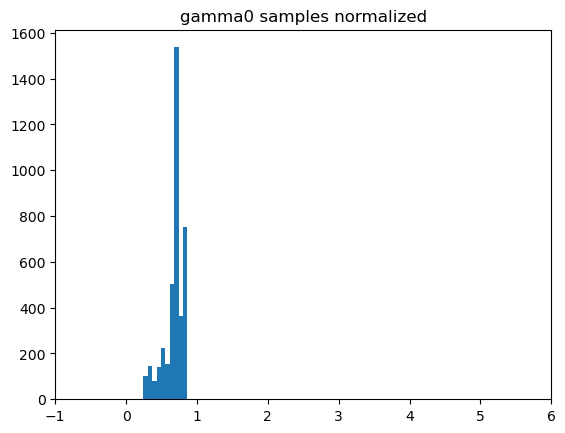

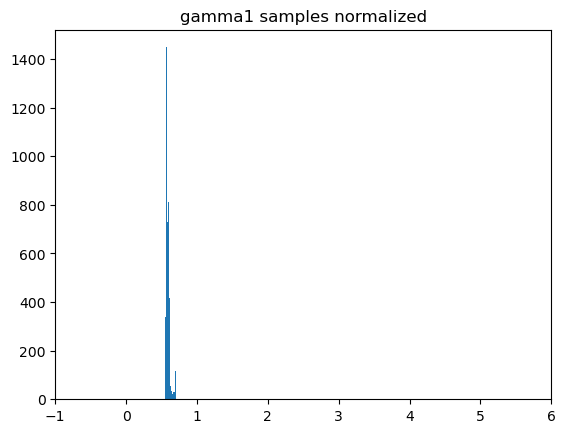

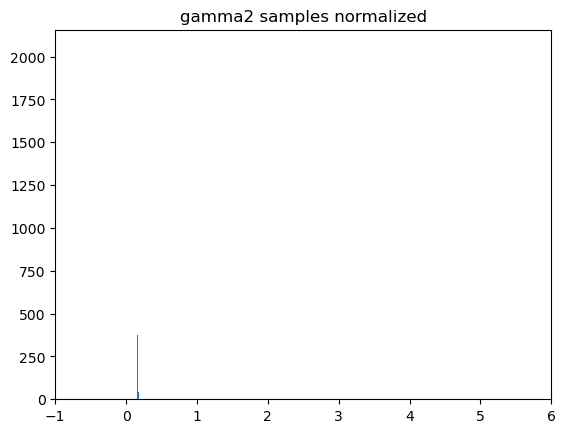

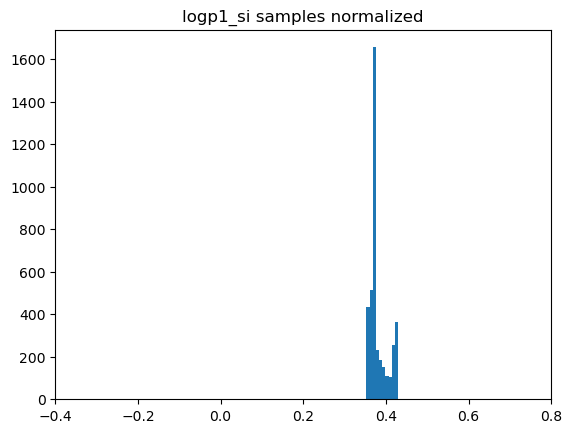

In [28]:
plt.hist(new_predictions[0])
plt.title("gamma0 samples normalized")
#print(np.min(new_predictions[0]))
#print(np.max(new_predictions[0]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[1])
plt.title("gamma1 samples normalized")
#print(np.min(new_predictions[1]))
#print(np.max(new_predictions[1]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[2])
plt.title("gamma2 samples normalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[3])
plt.title("logp1_si samples normalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
plt.xlim(-.4, .8)
plt.show()

plt.hist(new_predictions[4])
plt.title("logp2_si samples normalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
plt.xlim(-.4, .8)
plt.show()

un-normalized outputs histogram

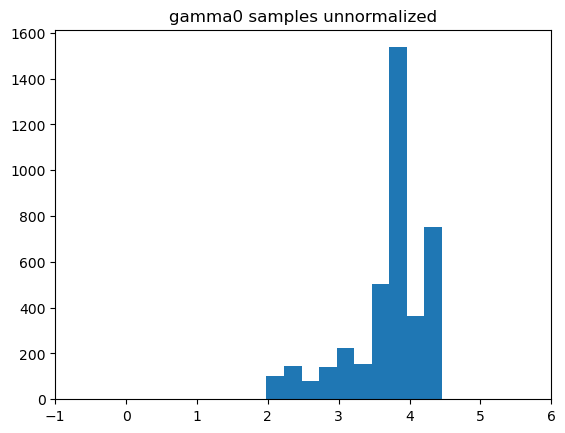

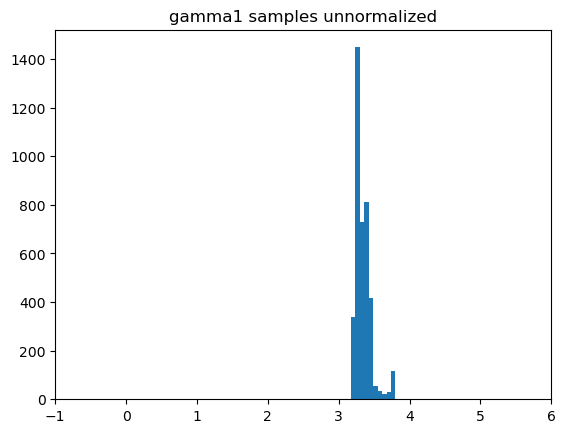

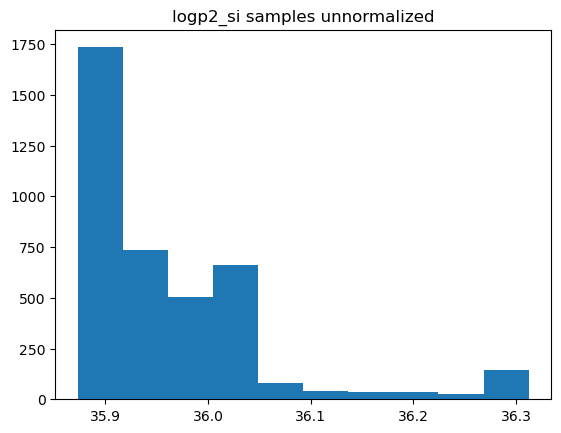

In [29]:
normgam0ar = []
for i in range (4000):
    normgam0ar.append(predictions[i][0])
plt.hist(normgam0ar)
plt.title("gamma0 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam1ar = []
for i in range (4000):
    normgam1ar.append(predictions[i][1])
plt.hist(normgam1ar)
plt.title("gamma1 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam2ar = []
for i in range (4000):
    normgam2ar.append(predictions[i][2])
plt.hist(normgam2ar)
plt.title("gamma2 samples unnormalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()


normlogp1ar = []
for i in range (4000):
    normlogp1ar.append(predictions[i][3])
plt.hist(normlogp1ar)
plt.title("logp1_si samples unnormalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
#plt.xlim(-.4, .8)
plt.show()


normlogp2ar = []
for i in range (4000):
    normlogp2ar.append(predictions[i][4])
plt.hist(normlogp2ar)
plt.title("logp2_si samples unnormalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
#plt.xlim(-.4, .8)
plt.show()

# Plot one EOS

In [30]:

# log(p1) & p2 ∈ [33, 37], in cgs
# [32, 36] in si
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

fgam0 = float(predictions[0][0])
print(fgam0)
fgam1 = float(predictions[0][1])
print(fgam1)
fgam2 = float(predictions[0][2])
print(fgam2)
flogp1 = float(predictions[0][3])
print(flogp1)
flogp2 = float(predictions[0][4]) 
print(flogp2)

3.683505058288574
3.2424569129943848
1.6411731243133545
34.47556686401367
35.8983268737793


In [31]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [32]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

In [33]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

Text(0, 0.5, 'pressure')

# EOS


In [34]:
#length = len(predictions)
length = 4000

In [41]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
bad = 0
for i in range(length):
    try: 
        g0 = float(predictions[i][0])
        g1 = float(predictions[i][1])
        g2 = float(predictions[i][2])
        p1 = float(predictions[i][3])
        p2 = float(predictions[i][4])

        if i%100==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.02)
        
    except:
        print("failed")
        bad += 1
        
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()
print(bad)

Progress : 0 / 4000, 0.00%
Progress : 100 / 4000, 2.50%
Progress : 200 / 4000, 5.00%
Progress : 300 / 4000, 7.50%
Progress : 400 / 4000, 10.00%
Progress : 500 / 4000, 12.50%
Progress : 600 / 4000, 15.00%
Progress : 700 / 4000, 17.50%
Progress : 800 / 4000, 20.00%
Progress : 900 / 4000, 22.50%
Progress : 1000 / 4000, 25.00%
Progress : 1100 / 4000, 27.50%
Progress : 1200 / 4000, 30.00%
Progress : 1300 / 4000, 32.50%
Progress : 1400 / 4000, 35.00%
Progress : 1500 / 4000, 37.50%
Progress : 1600 / 4000, 40.00%
Progress : 1700 / 4000, 42.50%
Progress : 1800 / 4000, 45.00%
Progress : 1900 / 4000, 47.50%
Progress : 2000 / 4000, 50.00%
Progress : 2100 / 4000, 52.50%
Progress : 2200 / 4000, 55.00%
Progress : 2300 / 4000, 57.50%
Progress : 2400 / 4000, 60.00%
Progress : 2500 / 4000, 62.50%
Progress : 2600 / 4000, 65.00%
Progress : 2700 / 4000, 67.50%
Progress : 2800 / 4000, 70.00%
Progress : 2900 / 4000, 72.50%
Progress : 3000 / 4000, 75.00%
Progress : 3100 / 4000, 77.50%
Progress : 3200 / 4000, 

0


# Actual Values EOS

In [38]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0-5000.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1-5000.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2-5000.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1-5000.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2-5000.dat.txt', dtype=float)
logp1 = np.loadtxt("eos_polytrope_log_pressure_1-5000.dat.txt", dtype=float)
logp2 = np.loadtxt("eos_polytrope_log_pressure_2-5000.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source-5000.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source-5000.dat.txt", dtype=float)

logp1_s = l1-1
logp2_s = l2-1

#length = len(gamma0)
length = 4000

In [39]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(gamma0[i])
    g1 = float(gamma1[i])
    g2 = float(gamma2[i])
    p1 = float(logp1_s[i])
    p2 = float(logp2_s[i])
    
    if i%100==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.05)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

Progress : 0 / 4000, 0.00%
Progress : 100 / 4000, 2.50%
Progress : 200 / 4000, 5.00%
Progress : 300 / 4000, 7.50%
Progress : 400 / 4000, 10.00%
Progress : 500 / 4000, 12.50%
Progress : 600 / 4000, 15.00%
Progress : 700 / 4000, 17.50%
Progress : 800 / 4000, 20.00%
Progress : 900 / 4000, 22.50%
Progress : 1000 / 4000, 25.00%
Progress : 1100 / 4000, 27.50%
Progress : 1200 / 4000, 30.00%
Progress : 1300 / 4000, 32.50%
Progress : 1400 / 4000, 35.00%
Progress : 1500 / 4000, 37.50%


GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure


RuntimeError: Generic failure

# Loss

In [42]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_si_output_loss', 'logp2_si_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_si_output_mean_squared_error', 'logp2_si_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_si_output_loss', 'val_logp2_si_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_si_output_mean_squared_error', 'val_logp2_si_output_mean_squared_error'])

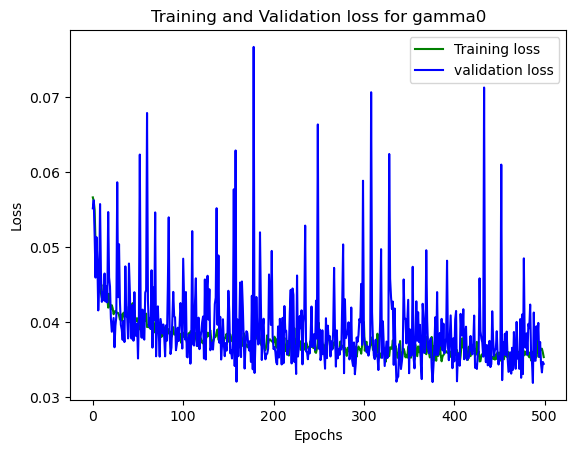

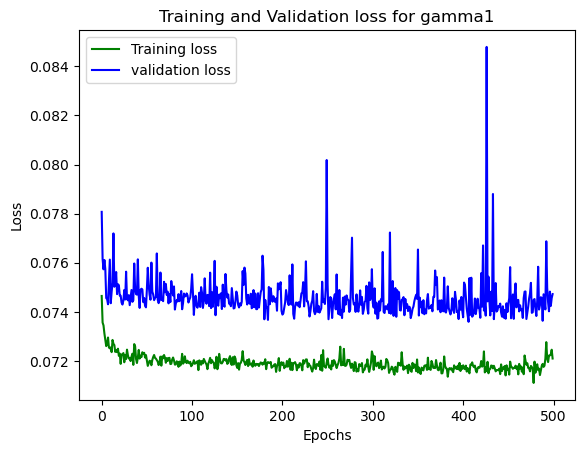

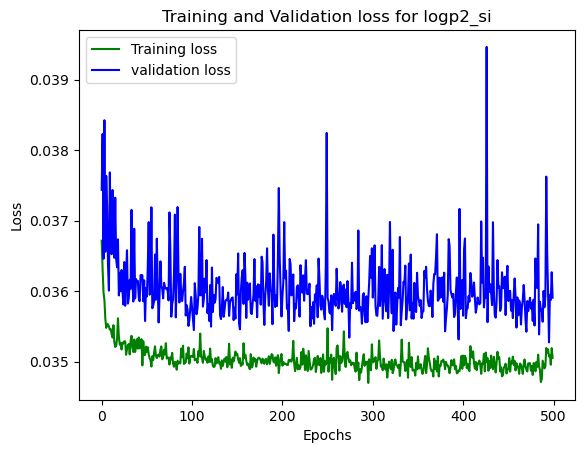

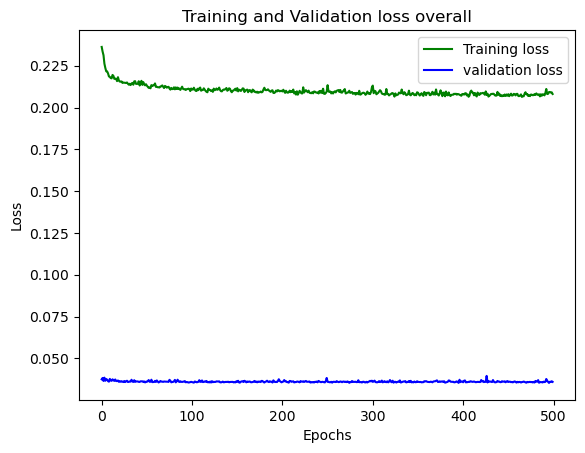

In [43]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#overall loss
loss_train = history.history['loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss overall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()